In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.models import *
plt.style.use('ggplot')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import plot_roc_curve, confusion_matrix, classification_report

In [3]:
fake_df = pd.read_csv('data/Fake.csv')
true_df = pd.read_csv('data/True.csv')

In [4]:
fake_df['truth'] = 0
true_df['truth'] = 1
true_df['text'] = true_df['text'].apply(clean_text)
all_news_df = pd.concat([fake_df, true_df])
all_news_df['title'] = all_news_df['title'].apply(clean_titles)

In [38]:
X_train, X_test, y_train, y_test = get_X_y_splits(all_news_df, 'title')

In [41]:
baseline_clf = baseline_model(X_train, y_train)
baseline_predicted = baseline_clf.predict(X_test)

In [7]:
nb_clf = naive_bayes_model(X_train,y_train)
nb_predicted = nb_clf.predict(X_test)
nb_clf.score(X_test,y_test)

0.907277428888068

In [8]:
sgd_clf = stochastic_gradient_descent_model(X_train,y_train)
sgd_predicted = sgd_clf.predict(X_test)
sgd_clf.score(X_test,y_test)

0.9403398596231991

In [44]:
pa_clf = passive_aggressive_model(X_train,y_train)
pa_predicted = pa_clf.predict(X_test)
pa_clf.score(X_test,y_test)

0.9474671669793621

In [10]:
# rf_clf = random_forest_model(X_train,y_train)
# rf_clf_predicted = rf_clf.predict(X_test)
# rf_clf.score(X_test,y_test)

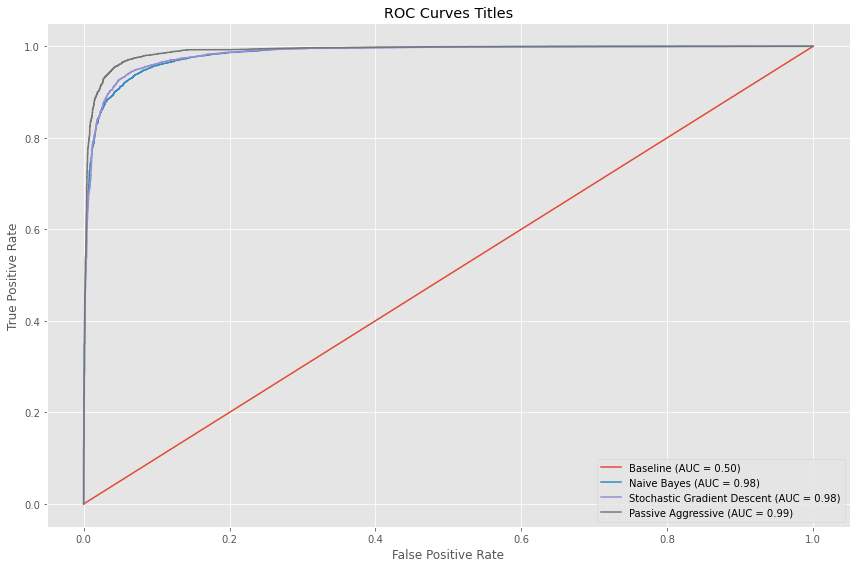

In [18]:
models = [baseline_clf, nb_clf, sgd_clf, pa_clf]
titles = ['Baseline','Naive Bayes', 'Stochastic Gradient Descent', 'Passive Aggressive']
fig, ax = plt.subplots(figsize=(12,8))
plot_all_roc_curves(X_test, y_test, models, titles, fig, ax, zoom=False, col='Titles')

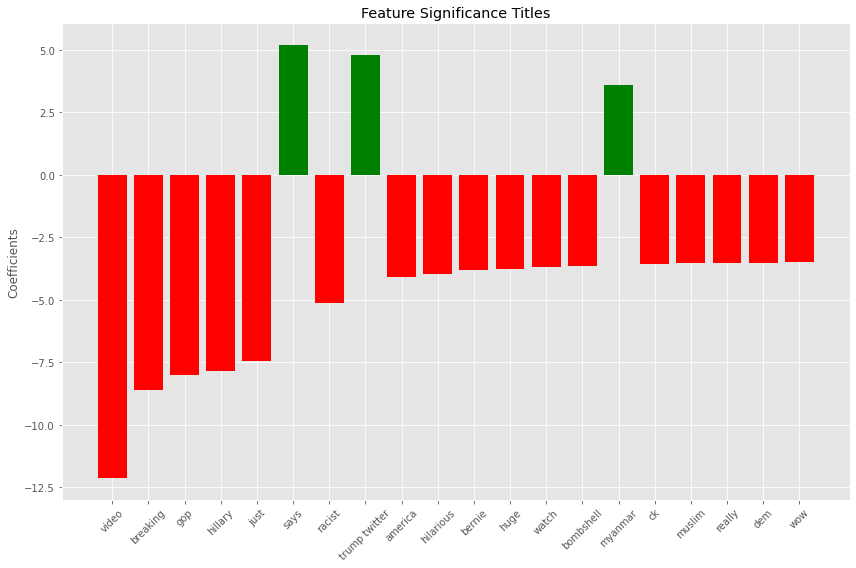

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
plot_feature_significance(pa_clf, fig, ax, col='Titles')

In [42]:
confusion_matrix(y_test, baseline_predicted)

array([[3103, 2792],
       [2855, 2475]])

In [13]:
confusion_matrix(y_test, nb_predicted)

array([[5531,  280],
       [ 502, 4912]])

In [14]:
confusion_matrix(y_test, sgd_predicted)

array([[5454,  357],
       [ 323, 5091]])

In [45]:
confusion_matrix(y_test, pa_predicted)

array([[5676,  219],
       [ 280, 5050]])

In [46]:
print(classification_report(y_test, pa_predicted, target_names=['Fake News','Real News']))

              precision    recall  f1-score   support

   Fake News       0.95      0.96      0.96      5895
   Real News       0.96      0.95      0.95      5330

    accuracy                           0.96     11225
   macro avg       0.96      0.96      0.96     11225
weighted avg       0.96      0.96      0.96     11225



In [47]:
test_title = ["Protesters ignite fury after shutting down packed Florida highway"]
pa_clf.predict(test_title)

array([0])

In [35]:
X_train_all = fake_df['text']

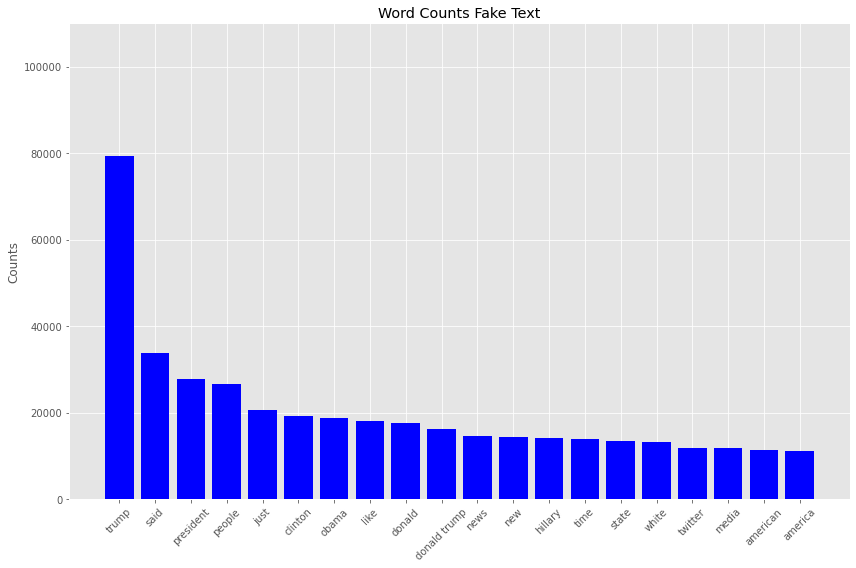

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_ylim(0,110000)
plot_word_counts(X_train_all, fig, ax, col='Fake Text')